# PnP物块位姿求解实验

## 导入依赖

In [2]:
import cv2
import numpy as np
from cv_color_cubic import *
from cv_camera import Camera
from matplotlib import pyplot as plt
from config import CUBIC_SIZE

## 读入摄像头数据

In [3]:
cam = Camera()

In [4]:
# 载入标定数据
cam.load_cam_calib_data()

## 提取角点

In [5]:
# 临时测试读取静态图像
img = cv2.imread('./data/image_raw/0.png')
canvas = np.copy(img)
ret, (cubic_rect,contour) = find_cubic_contour(img, RED_BLOCK_LOWERB, RED_BLOCK_UPPERB)
# 计算重投影之后的点
ret,result = get_cubic_corner(contour, canvas=canvas, blob_color=(0, 0, 255))
A2, B2, C2, D2, O = result

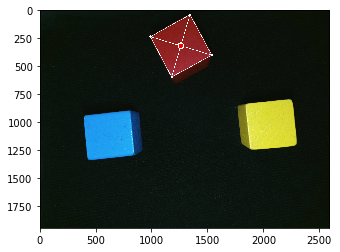

In [6]:
plt.imshow(canvas[:,:,::-1])

## PnP求解

上表面的四个点以及中心点对应到物块坐标系下的坐标(单位cm)

![](./image/物块坐标.jpg)

这里为了方便可视化, 将A,B,C,D点的z坐标设置为0, 物块的原点定义在上表面上.

In [19]:
r = CUBIC_SIZE/2.0
# 立方体坐标系下, 上表面角点与中心点的坐标
cubic_obj_pts = np.float32([
    [r, r, 0], # A点
    [r, -r, 0], # B点 
    [-r, -r, 0], # C点
    [-r, r, 0], # D点
])

# 立方体上表面在图像坐标系下的坐标
cubic_img_pts = np.float32([list(A2), list(B2), list(C2), list(D2)])

axis_len = CUBIC_SIZE * 1.5
# 立方体坐标系坐标轴的向量定义
axis_obj_pts = np.float32([
    [0, 0, 0], # 物块坐标系原点
    [axis_len, 0, 0], # X轴
    [0, axis_len, 0], # Y轴
    [0, 0, axis_len]]) # 

In [24]:
# 获得旋转向量与平移向量

# retval, rotation_vec, translation_vec = cv2.solvePnP(cubic_obj_pts, cubic_img_pts, cam.intrinsic, cam.distortion, flags=cv2.SOLVEPNP_IPPE_SQUARE)
retval, rotation_vec, translation_vec = cv2.solvePnP(cubic_obj_pts, cubic_img_pts, cam.intrinsic, cam.distortion, flags=cv2.SOLVEPNP_AP3P)

print(retval)
print("旋转向量: ")
print(rotation_vec)
print("平移向量: ")
print(translation_vec)

True
旋转向量: 
[[ 0.03054686]
 [-0.046522  ]
 [-0.51239335]]
平移向量: 
[[-0.39278754]
 [-5.12640907]
 [18.71866879]]


In [25]:
axis_img_pts, _ = cv2.projectPoints(axis_obj_pts, rotation_vec, translation_vec, cam.intrinsic, cam.distortion)
print(axis_img_pts)
axis_img_pts = tuple(map(tuple, axis_img_pts.reshape(4, 2)))
po, px, py, pz = axis_img_pts
print(axis_img_pts)

[[[1263.266     320.80487 ]]

 [[1786.4269     27.213957]]

 [[1554.4579    851.8142  ]]

 [[1248.2577    447.23395 ]]]
((1263.266, 320.80487), (1786.4269, 27.213957), (1554.4579, 851.8142), (1248.2577, 447.23395))


绘制坐标轴

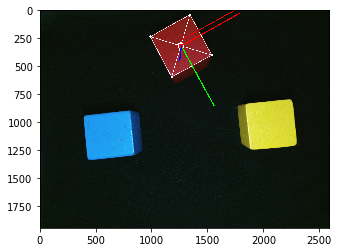

In [27]:
axis_thickness = 10
canvas = cv2.line(canvas, po, px, (0, 0, 255), thickness=axis_thickness)
canvas = cv2.line(canvas, po, py, (0, 255, 0), thickness=axis_thickness)
canvas = cv2.line(canvas, po, pz, (255, 0, 0), thickness=axis_thickness)

plt.imshow(canvas[:,:,::-1])

In [10]:
axis_img_pts

((1391.3317, 557.1085), (1644.4542, 283.75436), (1526.7042, -450.97247))

In [11]:
# 旋转向量
rotation_vec

array([[ 1.67867422],
       [ 1.45520047],
       [-0.0393415 ]])

求出来的这个平移向量也不对啊

In [12]:
# 平移向量
translation_vec

array([[-0.61524472],
       [-4.2376483 ],
       [12.10598833]])

从旋转向量提取欧拉角

## 参考

https://github.com/opencv/opencv/blob/master/samples/python/plane_ar.py

效果视频
https://www.youtube.com/watch?v=pzVbhxx6aog